# Brain Tumor Image Classification

## Problem Statement

We are given the dataset with images of patients' brains belonging to 2 classes: either healthy or with tumor. It is required to build a model that will successfully and accurately predict whether the patient is healthy or not.

## Data

**link** to Kaggle: https://www.kaggle.com/preetviradiya/brian-tumor-dataset

In [2]:
#importing libraries and objects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from keras.optimizers import Adam
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPool2D, Flatten, BatchNormalization

## Project Content

1) Data Import and Preparation for the model

2) Constructing the CNN

3) ROC-AUC curve, Optimal threshold detection

4) Precision-Recall curve, Optimal threshold detection

5) Confusion Matrix

6) Single Image Prediction(custom function)

7) Conclusion

## Data Import and Preparation for the model

In [28]:
#initialize image generator that will import the images itself
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split = 0.2)  # val 20%

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


train_data = train_datagen.flow_from_directory("/Users/polyanaboss/Downloads/brain_tumor images/Brain Tumor Data Set/Brain Tumor Data Set", 
                                               target_size = (64, 64), 
                                               color_mode = 'rgb',
                                               batch_size=  32, 
                                               class_mode = 'binary',
                                               shuffle = True,
                                               subset = 'training') 

val_data = val_datagen.flow_from_directory("/Users/polyanaboss/Downloads/brain_tumor images/Brain Tumor Data Set/Brain Tumor Data Set", 
                                           target_size=(64, 64), 
                                           color_mode ='rgb',
                                           batch_size = 32, 
                                           class_mode = 'binary',
                                           shuffle = False,
                                           subset = 'validation')

Found 3681 images belonging to 2 classes.
Found 919 images belonging to 2 classes.


In [29]:
#checking the labels
train_data.class_indices

{'Brain Tumor': 0, 'Healthy': 1}

Found 4514 files belonging to 2 classes.


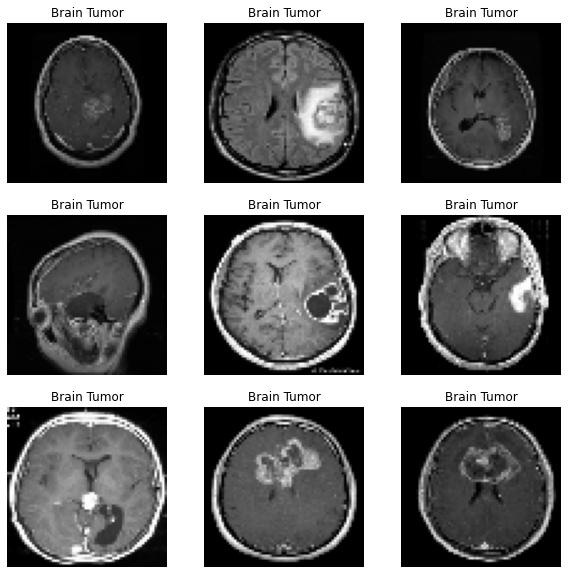

In [33]:
#visualizing several images of the brains
vis = tf.keras.preprocessing.image_dataset_from_directory("/Users/polyanaboss/Downloads/brain_tumor images/Brain Tumor Data Set/Brain Tumor Data Set",
                                                               image_size=(64,64),
                                                              shuffle = False)

class_names = vis.class_names
plt.figure(figsize=(10, 10))
for images, labels in vis.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


The data is ready to be transported into the Convolutional Neural Network. 

## Constructing the CNN

In [34]:
#instantiating the sequential model
cnn = Sequential()
#adding the convolutional layer
cnn.add(layers.Conv2D(filters = 32, kernel_size = 3, activation = "relu", input_shape = [64, 64, 3]))
#adding the normalization layer
cnn.add(BatchNormalization())
#pooling the most important parameters
cnn.add(MaxPool2D(2))

#repeating the same twice

cnn.add(layers.Conv2D(filters = 32, kernel_size = 3, activation = "relu", input_shape = [64, 64, 3]))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(2))


cnn.add(layers.Conv2D(filters = 32, kernel_size = 3, activation = "relu", input_shape = [64, 64, 3]))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(2))
#flatten the network
cnn.add(Flatten())
cnn.add(Dense(1, activation='sigmoid'))
#providing with the summary output
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        9

In [40]:
#compiling the model
cnn.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [41]:
#importing the callbacks
from keras.callbacks import EarlyStopping
# stop the fitting if there are 5 consequent epochs with no improvements
stop = EarlyStopping(patience = 5, restore_best_weights = True) 

In [42]:
#fitting the model
cnn.fit(train_data, validation_data = val_data, epochs = 50, callbacks = [stop])

Epoch 1/50
116/116 [==============================] - 24s 202ms/step - loss: 0.6226 - accuracy: 0.7002 - val_loss: 0.6315 - val_accuracy: 0.6551
Epoch 2/50
116/116 [==============================] - 18s 156ms/step - loss: 0.4142 - accuracy: 0.8120 - val_loss: 0.6070 - val_accuracy: 0.6594
Epoch 3/50
116/116 [==============================] - 18s 156ms/step - loss: 0.3878 - accuracy: 0.8276 - val_loss: 0.5020 - val_accuracy: 0.7606
Epoch 4/50
116/116 [==============================] - 18s 157ms/step - loss: 0.3424 - accuracy: 0.8510 - val_loss: 0.4254 - val_accuracy: 0.8085
Epoch 5/50
116/116 [==============================] - 19s 160ms/step - loss: 0.3744 - accuracy: 0.8353 - val_loss: 0.3060 - val_accuracy: 0.8640
Epoch 6/50
116/116 [==============================] - 18s 158ms/step - loss: 0.2831 - accuracy: 0.8928 - val_loss: 0.2325 - val_accuracy: 0.9108
Epoch 7/50
116/116 [==============================] - 18s 156ms/step - loss: 0.2477 - accuracy: 0.8970 - val_loss: 0.2663 - val_ac

In [43]:
#checking the validation accuracy
cnn.evaluate(val_data)

29/29 [==============================] - 2s 75ms/step - loss: 0.1281 - accuracy: 0.9445


[0.12814275920391083, 0.9445049166679382]

It is demonstrated here that CNN works extremely fine on our dataset with ~ 94% accuracy on the test set. Let us see the whole classification report.

In [68]:
#importing the report
from sklearn.metrics import classification_report

In [69]:
predictions = (cnn.predict(val_data) > .5)
print(classification_report(predictions, val_data.classes))

              precision    recall  f1-score   support

       False       0.96      0.94      0.95       517
        True       0.92      0.96      0.94       402

    accuracy                           0.94       919
   macro avg       0.94      0.95      0.94       919
weighted avg       0.95      0.94      0.94       919



## ROC-AUC curve

Next, one can visualize the output of the binary classification via well-known **ROC-AUC curve** or Receiver Operating Characteristic and Area Under the Curve. It shows the relationship between the True Positive Rate and False Positive Rate under different treshholds. 

In [91]:
#for simplicity, importing the special vis library to make things go faster
import scikitplot as skplt

In scikit-learn the models are giving the output via *predict_proba* as a list of 2 probabilities(e.g. [0.1, 0.9]), however, keras object does not. It gives us only 1 probability per observation. Hence, we need to modify the predictions a little bit in order to plot the curve

In [156]:
#unnest the list of lists with predictions
from itertools import chain
actual = val_data.classes
prob_predictions = cnn.predict(val_data)
probs = list(chain.from_iterable(prob_predictions))
final = []
#creating the new format
for el in probs:
    anti = 1 - el
    ls = [anti, el]
    final.append(ls)

#checking the output, everything seems correct
print(final[:3])

[[0.9930698573589325, 0.0069301426], [0.9969420433044434, 0.0030579567], [0.9998864674271317, 0.00011353257]]


In [158]:
#one more test for correctness
accuracy_score(np.array(final).argmax(axis = 1), actual)

0.9445048966267682

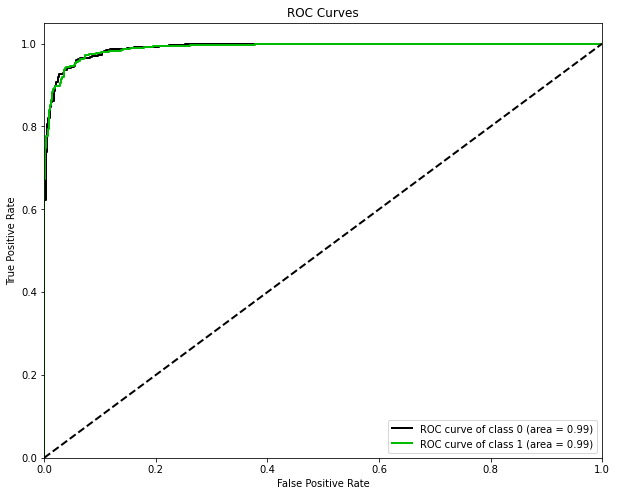

In [164]:
#visualizing the roc auc curve
skplt.metrics.plot_roc(actual, final, plot_macro = False, plot_micro = False, figsize = (10, 8),
                      classes_to_plot = [0, 1])

plt.show()

The curves show TPR and FPR while different thresholds are used. One can use this information in order to find the optimal value of threshold.

In [198]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(actual, cnn.predict(val_data))
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print(f'Best Threshold = {best_thresh}')

Best Threshold = 0.3590048551559448


In [201]:
#checking the accuracy with new value
pred_auc = (cnn.predict(val_data)>best_thresh)
# accuracy increases by ~0.05 and equals roughly 95%
accuracy_score(pred_auc, actual)

0.9510337323177367

## Precision-Recall Curve

One more similar metric is Precision-Recall Curve, which shows the relationship between 2 mentioned metrics. The logic and procedure are the same as for the ROC AUC analysis.

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

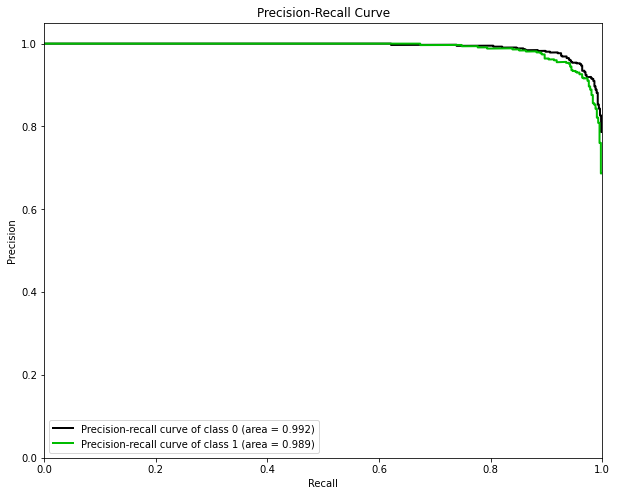

In [202]:
#plotting the curve
skplt.metrics.plot_precision_recall(actual, final, plot_micro=False, figsize=(10,8))

In [211]:
#calculating the metrics
precision, recall, threshs = metrics.precision_recall_curve(actual, prob_predictions)
#computing the harmonic mean for precision and recall
F1 = 2 * (precision * recall) / (precision + recall)
#location of the best threshold
f1_loc = np.argmax(F1)
best_f1 = threshs[f1_loc]
print(f"The Best Threshold for Precision-Recall Curve: {best_f1}")

The Best Threshold for Precision-Recall Curve: 0.3590048551559448


The result shows that for both ROC AUC and P-R curves the best threhold is about 0.35. It means that **if the probability of being healthy is 0.35 then the patient is healthy.**

In [213]:
#new classification report
print(classification_report(pred_auc, actual))

              precision    recall  f1-score   support

       False       0.96      0.95      0.96       507
        True       0.94      0.95      0.95       412

    accuracy                           0.95       919
   macro avg       0.95      0.95      0.95       919
weighted avg       0.95      0.95      0.95       919



With the help of 2 plots we increased the accuracy and other metrics by 0.05, which can be important while dealing with such diseases as brain tumor.

## Confusion Matrix

The last visualization that will show the precision and recall is confusion matrix

Text(0.5, 51.0, 'Prediction')

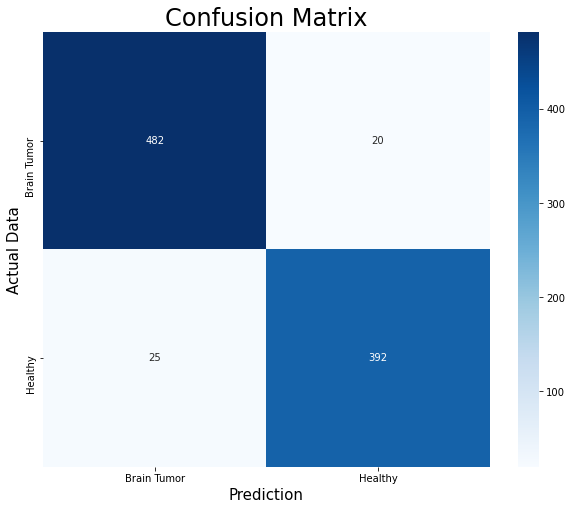

In [237]:
plt.figure(figsize = (10, 8))
sns.heatmap(confusion_matrix(actual, pred_auc), cmap = "Blues", annot = True, fmt = "d")
plt.title("Confusion Matrix", fontsize = 24)
plt.yticks(labels=["Brain Tumor", "Healthy"], ticks = [0.5,1.5], fontsize = 10)
plt.xticks(labels=["Brain Tumor", "Healthy"], ticks = [0.5,1.5], fontsize = 10)
plt.ylabel("Actual Data", fontsize = 15)
plt.xlabel("Prediction", fontsize = 15)

It is seen from the confusion matrix that only for 20 patients with real tumor the model predicts they are healthy. Meanwhile, only 25 healthy patients will receive the result that they have the disease.

## Single Image Prediction(custom function)

Once the model is trained, we can convert it to the function that will take the image path as an input and return the information whether there is a tumor or not.

In [266]:
#importing the image
from keras.preprocessing import image
#defining the function
def tumor_detection(image_path):
    test_image = image.load_img(image_path, target_size = (64,64))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    pred = cnn.predict(test_image)
    if pred > best_thresh:
        result = "Healthy"
        
    else: 
        result = "Brain Tumor"
   # Load the image
    photo = plt.imread(image_path)

    # Display the image
    photo = plt.imshow(photo)
    
    return print(f"Prediction: {result}\n{photo}")

Prediction: Healthy
AxesImage(54,36;334.8x217.44)


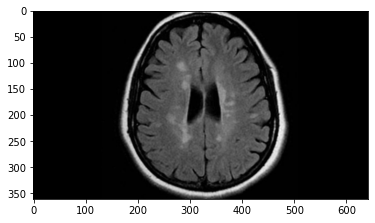

In [267]:
#function for healthy patient
tumor_detection("/Users/polyanaboss/Downloads/brain_tumor images/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (515).jpg")


Prediction: Brain Tumor
AxesImage(54,36;334.8x217.44)


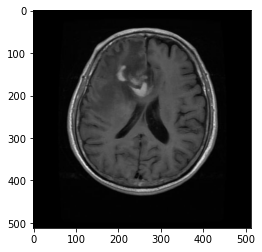

In [269]:
#function for patient with brain tumor
tumor_detection("/Users/polyanaboss/Downloads/brain_tumor images/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (4).jpg")


In [291]:
#final submission for the test set
import warnings
warnings.filterwarnings('ignore')

final_predictions = pred_auc
final_predictions = list(chain.from_iterable(final_predictions))
final_predictions = np.array(final_predictions).astype('uint8')

# Conclusion

In this notebook the image dataset of brain tumor was analyzed totalling 4600 images. The Convolutional Neural Network was built with **final accuracy(after ROC-AUC curve) about 95%** which seems great. The **optimal threshold** was detected to be ~ **0.35**, in other words, the patient is healthy if the probabilily to be healthy is only 0.35 and not default 0.5. All in all, the goal to detect the brain tumor accurately and precisely was achieved. 